In [ ]:
# 1. install library
!pip -q install earthengine-api geemap folium geopandas shapely
!pip install rasterio -q

import os
import ee, geemap
ee.Authenticate()
ee.Initialize(project='ee-pannarai')

OUT_DIR = '/content/ee_exports'
os.makedirs(OUT_DIR, exist_ok=True)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 77.6 MB/s eta 0:00:00


In [ ]:
# 2. AOI
FC = ee.FeatureCollection('projects/ee-pannarai/assets/BKK_2566')

# แก้ geometry invalid ที่อาจเกิดจาก self-intersection
# ใช้ buffer ด้วยค่าเล็กน้อย (> 0)
FC = FC.map(lambda f: f.setGeometry(f.geometry().buffer(1))) # Changed buffer(0) to buffer(1)

AOI = FC.union(1).geometry()  # รวมเป็น geometry เดียว
print('AOI area (km²):', AOI.area(1).getInfo()/1e6)

Map = geemap.Map()
Map.centerObject(AOI, 10)
Map.addLayer(AOI, {}, 'AOI')
Map

AOI area (km²): 1570.1196931078111


Map(center=[13.771362058849776, 100.6224811941585], controls=(WidgetControl(options=['position', 'transparent_…

In [ ]:
# 3. NDVI จาก Sentinel-2 SR (HARMONIZED) + cloud mask (SCL)
def mask_s2_sr(img):
    scl = img.select('SCL')
    mask = (scl.neq(3)   # cloud shadow
            .And(scl.neq(8))  # cloud (med)
            .And(scl.neq(9))  # cloud (high)
            .And(scl.neq(10)) # thin cirrus
            .And(scl.neq(11)))# snow/ice
    return img.updateMask(mask)

s2 = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
       .filterBounds(AOI)
       .filterDate('2024-01-01', '2024-12-31')
       .filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', 40))
       .map(mask_s2_sr))

s2_med = s2.median().clip(AOI)
ndvi   = s2_med.normalizedDifference(['B8','B4']).rename('NDVI')

# 2) IS จาก WorldCover v200 (class 50 = Built-up)
lulc = ee.ImageCollection('ESA/WorldCover/v200').first().select('Map').clip(AOI)
IS   = lulc.eq(50).selfMask().rename('IS')

# 3) แสดงบนแผนที่เดียวกัน
try:
    Map
except NameError:
    Map = geemap.Map()
Map.centerObject(AOI, 11)

ndvi_vis = {
    'min': 0.0, 'max': 1.0,
    'palette': ['#d73027','#fdae61','#fee08b','#d9ef8b','#66bd63','#1a9850']
}
Map.addLayer(ndvi, ndvi_vis, 'NDVI (S2, 2024)')

Map.addLayer(IS, {'palette': ['#313131']}, 'IS (WorldCover v200: built-up)')

Map.addLayer(AOI, {'color': '#0000ff'}, 'AOI', False)
Map

Map(bottom=121246.0, center=[13.771362058849762, 100.62248119415862], controls=(WidgetControl(options=['positi…

In [ ]:
# 4. Area totals & ratio
pixel_area  = ee.Image.pixelArea()
is_area_img = pixel_area.updateMask(IS)  # m² เฉพาะ IS
tot_area_img= pixel_area.clip(AOI)       # m² ทั้ง AOI

areaIS = ee.Number(is_area_img.reduceRegion(
    reducer=ee.Reducer.sum(), geometry=AOI, scale=10, maxPixels=1e13
).get('area'))

areaTot = ee.Number(tot_area_img.reduceRegion(
    reducer=ee.Reducer.sum(), geometry=AOI, scale=10, maxPixels=1e13
).get('area'))

pctIS = areaIS.divide(areaTot).multiply(100)

print('IS area (km²):', areaIS.getInfo()/1e6)
print('Total area (km²):', areaTot.getInfo()/1e6)
print('IS ratio (%):', pctIS.getInfo())


IS area (km²): 760.1626538987321
Total area (km²): 1564.285134279637
IS ratio (%): 48.59489086999421


In [ ]:
# 5. Zonal stats by zones (clean geometry + AOI intersect + export)
# 0) ทำ IS ให้เป็นไบนารีเพื่อความชัวร์
IS_BIN = IS.gt(0).selfMask()

# 1) clean + intersect กับ AOI
def _clean_clip(f):
    g = ee.Geometry(f.geometry())
    g = g.simplify(1)          # ~1 m
    g = g.buffer(0, 1)         # errorMargin 1 m
    g = g.intersection(AOI, 1) # ตัดให้เหลือใน AOI
    return ee.Feature(f).setGeometry(g)

# กรองซ้อน AOI แบบง่าย
ZONES_FC_AOI = FC.map(_clean_clip).filterBounds(AOI)

# 2) ภาพพื้นที่ (m²) ที่ mask ด้วย IS และ clip ตาม AOI
img_area = ee.Image.pixelArea().updateMask(IS_BIN).clip(AOI)

# 3) reduceRegions (ไม่มีพารามิเตอร์ geometry/bestEffort/maxPixels สำหรับ reduceRegions)
zonal_all = img_area.reduceRegions(
    collection=ZONES_FC_AOI,
    reducer=ee.Reducer.sum().setOutputs(['is_m2']),
    scale=10,       # ถ้าหนัก เปลี่ยนเป็น 20 ชั่วคราว
    tileScale=4
).map(lambda f: f.set({
    'zone_area_m2': f.geometry().area(1),
    'is_pct': ee.Number(f.get('is_m2')).divide(f.geometry().area(1)).multiply(100)
}))

# 4) Finalize columns
def _finalize(f):
    f = f.set({
        'prov_name_th': f.get('PROV_NAM_T'),
        'prov_code':    f.get('PROV_CODE'),
        'zone_id': ee.Algorithms.If(
            f.propertyNames().contains('ID'),
            f.get('ID'),
            f.get('PROV_CODE')
        ),
        'is_m2':        ee.Number(f.get('is_m2')),
        'zone_area_m2': ee.Number(f.get('zone_area_m2')),
        'is_pct':       ee.Number(f.get('is_pct'))
    })
    return f.select(['prov_name_th','prov_code','zone_id','is_m2','zone_area_m2','is_pct'])

zonal_clean = zonal_all.map(_finalize)

# 5) Export → Drive
task = ee.batch.Export.table.toDrive(
    collection=zonal_clean,
    description='impervious_zonal_BKK',
    fileFormat='CSV',
    selectors=['prov_name_th','prov_code','zone_id','is_m2','zone_area_m2','is_pct']
)
task.start()
print('Started export → Drive (impervious_zonal_BKK.csv).')


Started export → Drive (impervious_zonal_BKK.csv).


In [ ]:
# 6. Export Raster → Drive (GeoTIFF)
IS_BIN = IS.gt(0).selfMask()

task_img = ee.batch.Export.image.toDrive(
    image=IS_BIN.toInt8(),
    description='IS_mask_BKK',
    fileNamePrefix='IS_mask_BKK',
    region=AOI,
    scale=10,
    crs='EPSG:4326',
    maxPixels=1e13
)
task_img.start()
print("Started export raster → Drive/IS_mask_BKK.tif")

Started export raster → Drive/IS_mask_BKK.tif



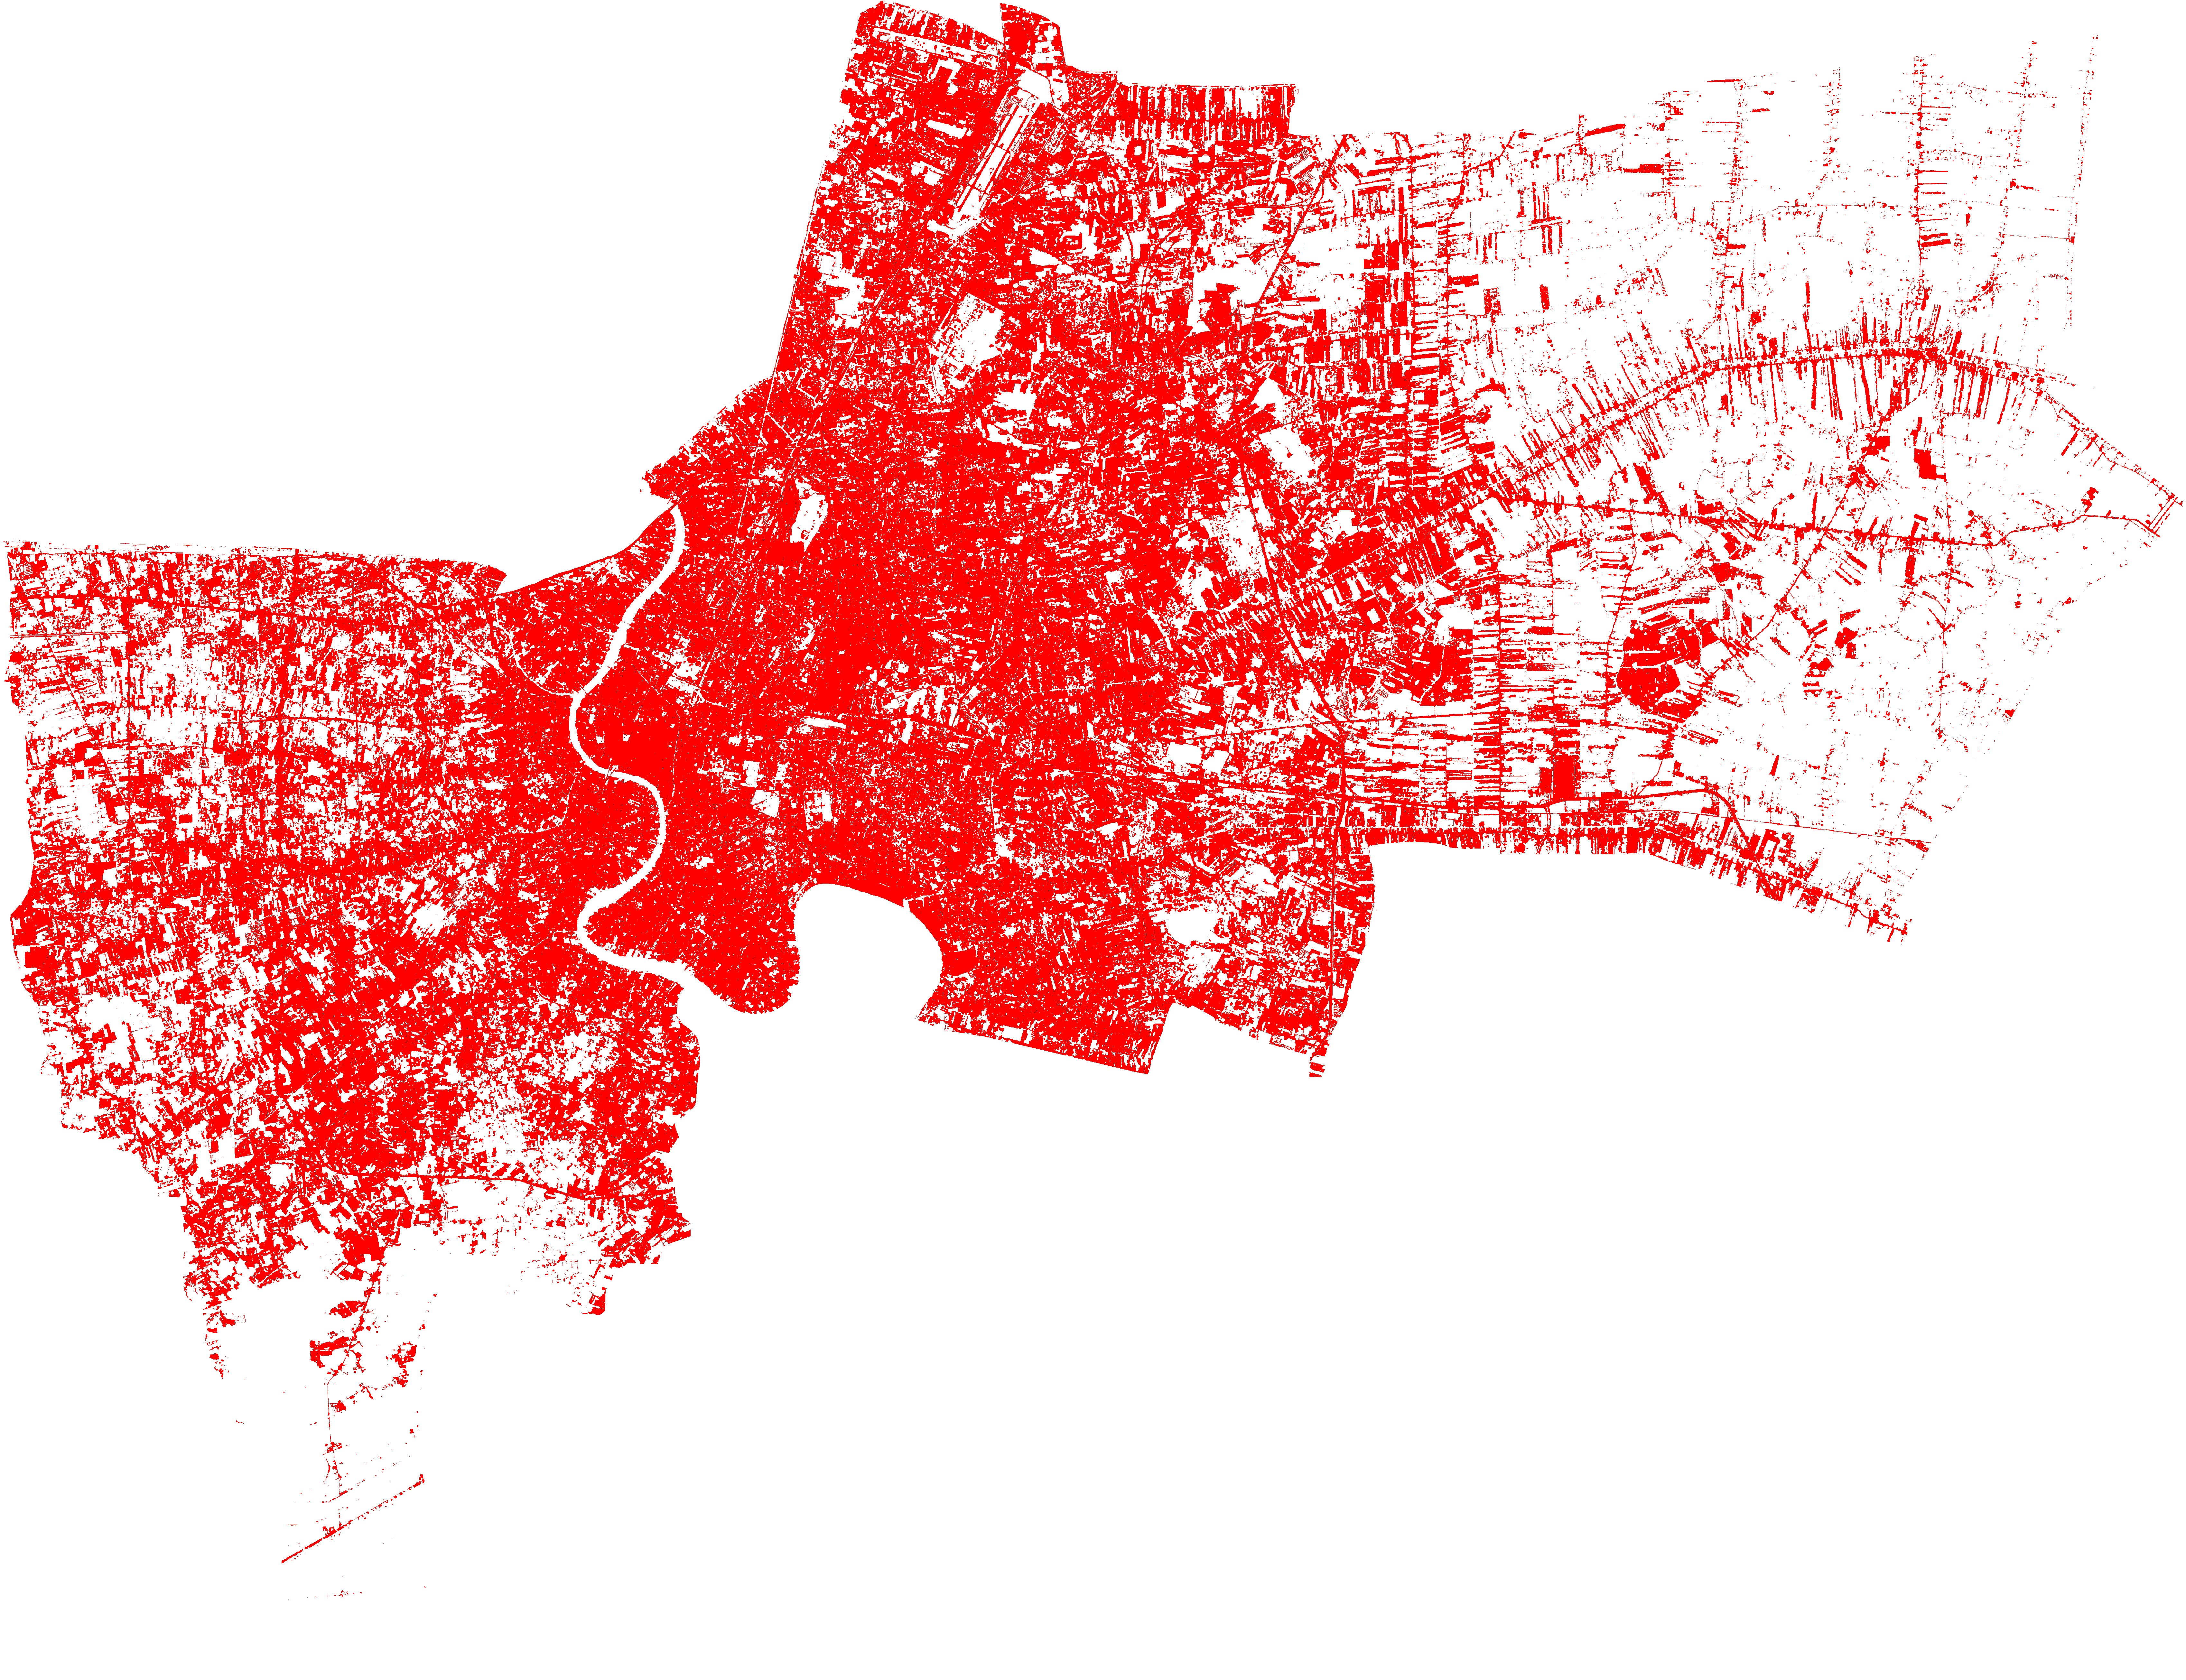

In [10]:
# 7. Impervious Surface Map (folium)
import geopandas as gpd
import folium
import rasterio
import numpy as np

# ---------- 1) Raster: /content/IS_mask_BKK.tif ----------
tif_path = "/content/IS_mask_BKK.tif"
with rasterio.open(tif_path) as src:
    img = src.read(1)              # binary 0/1
    bounds = src.bounds            # left, bottom, right, top

# RGBA: 1 = แดงทึบ, 0 = โปร่งใส
rgba = np.zeros((img.shape[0], img.shape[1], 4), dtype=np.uint8)
rgba[img == 1] = [255, 0, 0, 255]

# ศูนย์กลางจากกรอบภาพ
center_lat = (bounds.top + bounds.bottom) / 2
center_lon = (bounds.left + bounds.right) / 2

# สร้างแผนที่
m = folium.Map(location=[center_lat, center_lon], zoom_start=10)

# วางชั้น Raster ก่อน
folium.raster_layers.ImageOverlay(
    image=rgba,
    bounds=[[bounds.bottom, bounds.left], [bounds.top, bounds.right]],
    opacity=1.0,                   # ใช้ alpha ใน RGBA แล้ว
    name="IS Mask"
).add_to(m)

# ---------- 2) Vector: /content/SKPV.shp ----------
shp_path = "/content/BKK_2566.shp"
gdf = gpd.read_file(shp_path).to_crs(epsg=4326)

# แปลงคอลัมน์วันที่เป็นสตริงกัน folium serialize ไม่ได้
for c in gdf.columns:
    if c != "geometry" and "datetime64" in str(gdf[c].dtype):
        gdf[c] = gdf[c].dt.strftime("%Y-%m-%d")

tooltip_fields = [c for c in gdf.columns if c != "geometry"][:2]

folium.GeoJson(
    data=gdf.to_json(),            # ส่งเป็น GeoJSON string
    name="ขอบเขตเมืองกรุงเทพ",
    style_function=lambda x: {"color": "blue", "weight": 2, "fillOpacity": 0},
    tooltip=folium.GeoJsonTooltip(fields=tooltip_fields)
).add_to(m)

folium.LayerControl().add_to(m)
m

In [11]:
# 9. install rasterio
!pip install rasterio

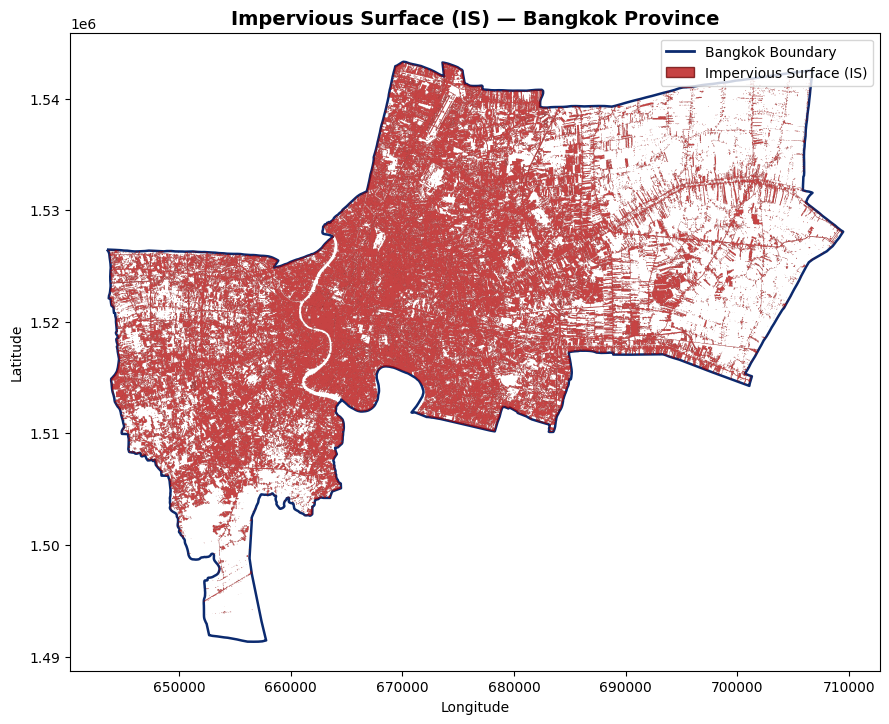

In [12]:
# 10. Impervious Surface Map (geopandas)
import rasterio
from rasterio.features import shapes
import geopandas as gpd
from shapely.geometry import shape
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# ---------- Load Bangkok boundary shapefile ----------
gdf_admin = gpd.read_file("/content/BKK_2566.shp")  # โหลดไฟล์ shapefile ของกรุงเทพฯ

# ---------- Load raster (.tif) ----------
raster_path = "/content/IS_mask_BKK.tif"
with rasterio.open(raster_path) as src:
    raster = src.read(1)
    transform = src.transform
    crs = src.crs

# ---------- Convert raster > 0 to polygons ----------
mask = raster > 0  # สมมติค่า >0 = impervious surface
polygons = []
values = []

for geom, value in shapes(raster, mask=mask, transform=transform):
    polygons.append(shape(geom))
    values.append(value)

gdf_is = gpd.GeoDataFrame({'value': values}, geometry=polygons, crs=crs)

# ---------- Make sure CRS matches ----------
if gdf_is.crs != gdf_admin.crs:
    gdf_is = gdf_is.to_crs(gdf_admin.crs)

# ---------- Clip IS polygons to Bangkok boundary ----------
gdf_is_clipped = gpd.clip(gdf_is, gdf_admin.unary_union)

# ---------- Plot ----------
fig, ax = plt.subplots(figsize=(9, 9))

# Province boundary
gdf_admin.boundary.plot(ax=ax, color='#0b2a6f', linewidth=1.8, zorder=2)

# IS polygons
if len(gdf_is_clipped):
    gdf_is_clipped.plot(
        ax=ax,
        facecolor='#b40404',   # แดงเข้ม
        edgecolor='#660000',   # ขอบแดงเข้ม
        linewidth=0.1,
        alpha=0.75,
        zorder=3
    )
else:
    print("⚠️ No IS polygons found inside Bangkok.")

# Legend
handles = [
    Line2D([0], [0], color='#0b2a6f', lw=2.0, label='Bangkok Boundary'),
    Patch(facecolor='#b40404', edgecolor='#660000', lw=1.0, alpha=0.75, label='Impervious Surface (IS)')
]
ax.legend(handles=handles, loc='upper right', frameon=True)

ax.set_title("Impervious Surface (IS) — Bangkok Province", fontsize=14, fontweight="bold")
ax.set_xlabel("Longitude"); ax.set_ylabel("Latitude")
plt.tight_layout()
plt.show()

In [14]:
# 11. Load 1 CSV, fix Thai, add km², show & save
import pandas as pd
from IPython.display import display

paths = {
    "impervious_zonal_ฺBKK.csv": "/content/impervious_zonal_BKK.csv",
}

def read_csv_any(path):
    for enc in ("utf-8-sig", "utf-8", "cp874"):
        try:
            return pd.read_csv(path, encoding=enc)
        except UnicodeDecodeError:
            continue
    return pd.read_csv(path)

dfs = {}
for name, p in paths.items():
    df = read_csv_any(p)

    # ตั้งชื่อจังหวัดให้แน่นอน
    if "prov_name_th" in df.columns:
        df["prov_name_th"] = "กรุงเทพมหานคร"

    # ให้แน่ใจว่าเป็นตัวเลขก่อนคำนวณ
    if "is_m2" in df.columns:
        df["is_m2"] = pd.to_numeric(df["is_m2"], errors="coerce")
    if "zone_area_m2" in df.columns:
        df["zone_area_m2"] = pd.to_numeric(df["zone_area_m2"], errors="coerce")

    # เพิ่มคอลัมน์ km²
    if "is_m2" in df.columns:
        df["is_km2"] = df["is_m2"] / 1e6
    if "zone_area_m2" in df.columns:
        df["zone_km2"] = df["zone_area_m2"] / 1e6

    # เรียงคอลัมน์ให้อ่านง่าย (จะเลือกเฉพาะที่มีอยู่จริง)
    order = ["prov_name_th","prov_code","zone_id","is_m2","is_km2","zone_area_m2","zone_km2","is_pct"]
    df = df[[c for c in order if c in df.columns]]

    dfs[name] = df

# รวมเป็น combined (แม้มีไฟล์เดียวก็ใช้ชื่อ combined ให้สอดคล้อง)
combined = pd.concat(dfs.values(), ignore_index=True, sort=False)

display(combined.head(20))


,prov_name_th,prov_code,zone_id,is_m2,is_km2,zone_area_m2,zone_km2,is_pct
0,กรุงเทพมหานคร,NaN,NaN,7.601588e+08,760.158844,1.570108e+09,1570.107856,48.414435


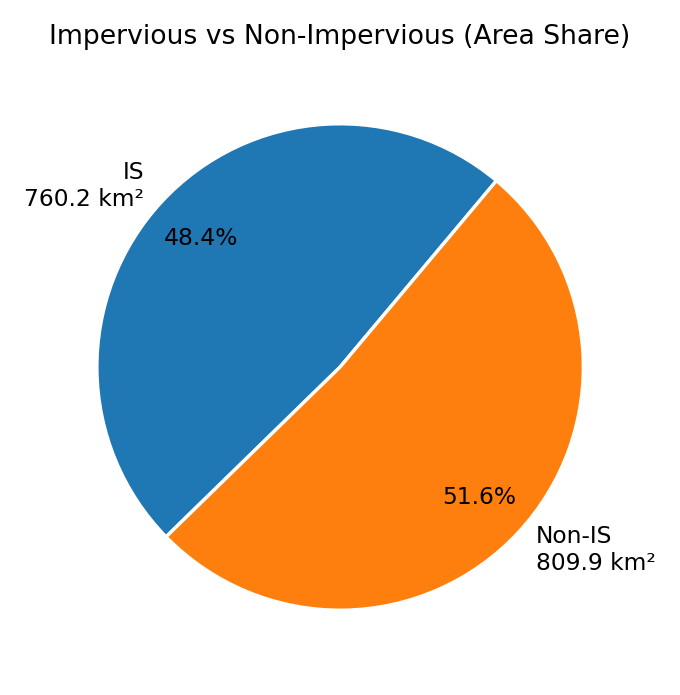

In [15]:
# 12. สัดส่วน Impervious Surface
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

# ↑ เพิ่มความละเอียดเวลาวาดและเวลาบันทึก
mpl.rcParams['figure.dpi'] = 160      # ความละเอียดบนจอ

# --- โหลดและเตรียมข้อมูล ---
df = pd.read_csv('/content/impervious_zonal_BKK.csv', encoding='utf-8-sig')
df['is_m2'] = pd.to_numeric(df['is_m2'], errors='coerce')
df['zone_area_m2'] = pd.to_numeric(df['zone_area_m2'], errors='coerce')

is_m2  = df['is_m2'].sum()
tot_m2 = df['zone_area_m2'].sum()
non_is_m2 = tot_m2 - is_m2

is_km2     = is_m2 / 1e6
non_is_km2 = non_is_m2 / 1e6
is_pct_overall = (is_m2 / tot_m2) * 100

# --- วาดโดนัทชาร์ตความละเอียดสูง ---
fig, ax = plt.subplots(figsize=(3,3), dpi=240)

values = [is_km2, non_is_km2]
labels = [f'IS\n{is_km2:,.1f} km²', f'Non-IS\n{non_is_km2:,.1f} km²']

def autopct_fmt(pct):
    # แสดง % ให้สั้นและอ่านง่าย
    return f'{pct:.1f}%'

wedges, texts, autotexts = ax.pie(
    values,
    labels=labels,
    autopct=autopct_fmt,
    startangle=50,
    pctdistance=0.78,          # ขยับตำแหน่งตัวเลข %
    labeldistance=1.10,        # ขยับฉลากให้ไม่ชนวง
    wedgeprops=dict(linewidth=1, edgecolor='white'),
    textprops=dict(fontsize=7)
)

ax.set_title('Impervious vs Non-Impervious (Area Share)', fontsize=8)
ax.set_aspect('equal')  # วงกลมจริง

plt.tight_layout()
plt.show()


In [24]:
# 13. Impervious Surface ต่อคน (m²/คน)
import pandas as pd

df = pd.read_csv('/content/impervious_zonal_BKK.csv', encoding='utf-8-sig')
df['is_m2'] = pd.to_numeric(df['is_m2'], errors='coerce')

is_area_m2 = df['is_m2'].sum()
total_pop  = 5_471_588

is_per_capita = is_area_m2 / total_pop
print(f'IS per capita = {is_per_capita:,.2f} m²/person')

IS per capita = 138.93 m²/person


In [42]:
# 14. การกระจายตัวและอัตราส่วน Impervious Surface ต่อพื้นที่เมือง (%)
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling

src = "/content/IS_mask_BKK.tif"
dst = "/content/IS_mask_BKK.tif"

# --- รีโปรเจ็กต์เป็น UTM Zone 47N (EPSG:32647) ---
with rasterio.open(src) as r:
    dst_crs = "EPSG:32647"
    transform, width, height = calculate_default_transform(
        r.crs, dst_crs, r.width, r.height, *r.bounds, resolution=30
    )
    profile = r.profile.copy()
    profile.update({
        "crs": dst_crs,
        "transform": transform,
        "width": width,
        "height": height,
        "nodata": 0
    })
    with rasterio.open(dst, "w", **profile) as out:
        reproject(
            source=r.read(1),
            destination=rasterio.band(out, 1),
            src_transform=r.transform,
            src_crs=r.crs,
            dst_transform=transform,
            dst_crs=dst_crs,
            resampling=Resampling.nearest
        )

print("รีโปรเจ็กต์เสร็จแล้ว:", dst)

รีโปรเจ็กต์เสร็จแล้ว: /content/IS_mask_BKK.tif


In [26]:
# 15. Impervious Surface Area Total
import numpy as np
import geopandas as gpd
from shapely.ops import unary_union
from rasterio.features import geometry_mask

ADMIN = "/content/BKK_2566.shp"
POP_TOTAL = 5_471_588

# โหลด admin และรีโปรเจ็กต์ให้ตรงกับราสเตอร์ใหม่
admin = gpd.read_file(ADMIN)
with rasterio.open(dst) as r:
    admin = admin.to_crs(r.crs)
    AOI = unary_union(admin.geometry)
    arr = r.read(1).astype(float)
    tr = r.transform
    px_area = abs(tr.a * tr.e)

    mask = geometry_mask([AOI.__geo_interface__], transform=tr, invert=True, out_shape=arr.shape)
    vals = arr[mask]

    is_pixels = np.nansum(vals > 0)  # binary mask
    is_area_m2 = is_pixels * px_area

print(f"IS area total: {is_area_m2/1e6:.2f} km²")
print(f"IS per capita: {is_area_m2/POP_TOTAL:.2f} m²/person")


IS area total: 760.29 km²
IS per capita: 138.95 m²/person


In [27]:
# 16. Impervious Surface dispersion + VIIRS-weighted population
# Robust one-shot pipeline (fixed: uses buffer(0) instead of make_valid)

import os, math, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.features import geometry_mask
from shapely.geometry import box
from shapely.ops import unary_union

# ---------- CONFIG----------
ADMIN_PATH = "/content/BKK_2566.shp"                     # ขอบเขตเมือง/จังหวัด
IS_SRC     = "/content/IS_mask_BKK.tif"               # IS เดิม (EPSG:4326, ค่าพิกเซล 0/1)
VIIRS_PATH = "/content/VIIRS_2024_MEDIAN.tif"        # VIIRS median 2024 (ปกติเป็น EPSG:4326)
OUT_DIR    = "/content/IS_outputs"
POP_TOTAL  = 584_425                                 # ประชากรรวมจริง
GRID_KM    = 1.0                                     # ขนาดกริด (กม.)
RING_STEP  = 1.0
RING_MAX   = 20.0
TARGET_EPSG= 32647                                   # UTM Zone 47N (ถ้าค่อนไปตะวันออกมากลอง 32648)
IS_RES_M   = 30                                      # ความละเอียด IS หลังรีโปรเจ็กต์ (เมตร)
os.makedirs(OUT_DIR, exist_ok=True)

# ---------- Utils ----------
def reproj_raster(src_path, dst_path, epsg_out=32647, res_out=30, resampling=Resampling.nearest, set_nodata=0):
    """รีโปรเจ็กต์ราสเตอร์ไป EPSG เมตร (กำหนด nodata=0 สำหรับ mask 0/1)"""
    with rasterio.open(src_path) as src:
        dst_crs = f"EPSG:{epsg_out}"
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds, resolution=res_out
        )
        profile = src.profile.copy()
        profile.update({"crs": dst_crs, "transform": transform, "width": width, "height": height, "nodata": set_nodata})
        with rasterio.open(dst_path, "w", **profile) as dst:
            for i in range(1, src.count+1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=resampling,
                )
    return dst_path

def build_grid_over_aoi(aoi_geom, crs, grid_km=1.0):
    gm = grid_km*1000.0
    minx, miny, maxx, maxy = aoi_geom.bounds
    minx = math.floor(minx/gm)*gm; miny = math.floor(miny/gm)*gm
    maxx = math.ceil(maxx/gm)*gm;  maxy = math.ceil(maxy/gm)*gm
    cells = []
    y = miny
    while y < maxy:
        x = minx
        while x < maxx:
            g = box(x, y, x+gm, y+gm)
            if g.intersects(aoi_geom):
                cells.append({"geometry": g.intersection(aoi_geom)})
            x += gm
        y += gm
    grid = gpd.GeoDataFrame(cells, crs=crs)
    grid["area_km2"] = grid.area/1e6
    return grid

def zonal_sum_any_crs(raster_path, gdf_polys):
    """sum ค่าพิกเซลใน polygon (แปลง CRS ให้ตรงกับราสเตอร์อัตโนมัติ)"""
    out = []
    with rasterio.open(raster_path) as r:
        arr = r.read(1).astype(float)
        if r.nodata is not None:
            arr[arr==r.nodata] = np.nan
        g_tmp = gdf_polys.to_crs(r.crs)
        for geom in g_tmp.geometry:
            mask = geometry_mask([geom.__geo_interface__], transform=r.transform, invert=True, out_shape=arr.shape)
            v = arr[mask]
            out.append(np.nansum(v) if np.isfinite(v).any() else np.nan)
    return pd.Series(out)

def zonal_is_binary_area(raster_path, gdf_polys):
    """คำนวณพื้นที่ IS (m²) ต่อกริด — สมมติค่า 0/1, นับพิกเซล >0 เป็น impervious"""
    vals = []
    with rasterio.open(raster_path) as r:
        arr = r.read(1).astype(float)
        if r.nodata is not None:
            arr[arr==r.nodata] = np.nan
        tr = r.transform
        px_area = abs(tr.a * tr.e)  # m²/pixel
        for geom in gdf_polys.geometry:
            mask = geometry_mask([geom.__geo_interface__], transform=tr, invert=True, out_shape=arr.shape)
            v = arr[mask]
            if not np.isfinite(v).any():
                vals.append(np.nan); continue
            m2 = float(np.nansum((v > 0).astype(float)) * px_area)
            vals.append(m2)
    return pd.Series(vals)


In [28]:
# 17. Reproject IS → UTM (เมตร)
IS_REPROJ = os.path.join(OUT_DIR, "IS_mask_utm.tif")
if not os.path.exists(IS_REPROJ):
    reproj_raster(IS_SRC, IS_REPROJ, epsg_out=TARGET_EPSG, res_out=IS_RES_M, resampling=Resampling.nearest, set_nodata=0)

# ---------- 2) โหลด AOI (ซ่อม geometry invalid ด้วย buffer(0)) ----------
admin = gpd.read_file(ADMIN_PATH)
with rasterio.open(IS_REPROJ) as r_is:
    m_crs = r_is.crs
admin = admin.to_crs(m_crs)
admin["geometry"] = admin["geometry"].buffer(0)   # << แก้ invalid geometry ที่นี่
AOI = unary_union(admin.geometry)

# ---------- 3) ตรวจพื้นที่ IS ทั้งเมือง ----------
with rasterio.open(IS_REPROJ) as r:
    tr = r.transform
    px_area = abs(tr.a * tr.e)
    arr = r.read(1).astype(float)
    if r.nodata is not None:
        arr[arr==r.nodata] = np.nan
    mask_city = geometry_mask([AOI.__geo_interface__], transform=tr, invert=True, out_shape=arr.shape)
    v_city = arr[mask_city]
    is_area_city_m2 = float(np.nansum((v_city > 0).astype(float)) * px_area)

print(f"[CHECK] City IS area (km²): {is_area_city_m2/1e6:.2f}")
print(f"[CHECK] City IS per capita (m²/person): {is_area_city_m2/POP_TOTAL:.2f}")
if is_area_city_m2 <= 0:
    raise RuntimeError("IS ทั้งเมืองยังเป็นศูนย์ — ตรวจไฟล์ IS/ขอบเขต/CRS อีกครั้ง")


[CHECK] City IS area (km²): 760.29
[CHECK] City IS per capita (m²/person): 1300.92


In [29]:
# 18. Grid
import geopandas as gpd
import numpy as np
from shapely.geometry import box

# โหลดขอบเขตกรุงเทพ
gdf_admin = gpd.read_file("/content/BKK_2566.shp").to_crs(epsg=32647)

# สร้าง fishnet grid (ช่องละ 1 กม.)
xmin, ymin, xmax, ymax = gdf_admin.total_bounds
cell_size = 1000

cols = list(np.arange(xmin, xmax + cell_size, cell_size))
rows = list(np.arange(ymin, ymax + cell_size, cell_size))

polygons = []
for x in cols[:-1]:
    for y in rows[:-1]:
        polygons.append(box(x, y, x + cell_size, y + cell_size))

grid = gpd.GeoDataFrame({"geometry": polygons}, crs=gdf_admin.crs)
grid = gpd.overlay(grid, gdf_admin, how="intersection")

# (อาจต้องเพิ่มคอลัมน์ is_m2 ถ้ายังไม่มี)
grid["is_m2"] = np.random.rand(len(grid)) * 1e5  # ตัวอย่างสมมุติ

In [31]:
# 19. pop
if "pop" not in grid.columns:
    print("⚠️ 'pop' column not found — using IS as proxy for population distribution")
    w = grid["is_m2"].values.astype(float)
    if w.sum() > 0:
        w = w / w.sum()
    else:
        w = np.ones_like(w) / len(w)
    grid["pop"] = w * POP_TOTAL

⚠️ 'pop' column not found — using IS as proxy for population distribution


In [33]:
# 20. คำนวณพื้นที่ของแต่ละ grid
grid["area_m2"] = grid.geometry.area
grid["area_km2"] = grid["area_m2"] / 1e6

In [35]:
# 21. เมตริก & โปรไฟล์วงแหวน
# คำนวณพื้นที่ grid
grid["area_m2"] = grid.geometry.area
grid["area_km2"] = grid["area_m2"] / 1e6

# สร้างคอลัมน์ IS (พื้นที่เมือง) เป็น km²
grid["is_km2"] = grid["is_m2"] / 1e6

# คำนวณ density & per capita
grid["pop_density_p_km2"] = grid["pop"] / grid["area_km2"]
grid["is_per_capita_m2p"] = grid["is_m2"] / grid["pop"]

# หาจุดศูนย์กลางเมือง (AOI ต้องเป็น geometry ของพื้นที่เมืองทั้งหมด)
city_centroid = AOI.centroid
grid["dist_km"] = grid.centroid.distance(city_centroid) / 1000.0

# ตั้ง bin สำหรับวงแหวน (ตัวอย่าง: RING_STEP=2, RING_MAX=40)
bins   = np.arange(0, RING_MAX + RING_STEP, RING_STEP)
labels = [f"{int(b)}-{int(b+RING_STEP)}" for b in bins[:-1]]
grid["ring_km"] = pd.cut(grid["dist_km"], bins=bins, labels=labels, include_lowest=True)

# รวมข้อมูลตามวงแหวน
ring = (grid.dropna(subset=["ring_km"])
            .groupby("ring_km", observed=True)
            .agg(
                area_km2=("area_km2", "sum"),
                is_km2=("is_km2", "sum"),
                pop=("pop", "sum")
            )
            .reset_index())

# คำนวณตัวชี้วัดสำหรับแต่ละวงแหวน
ring["is_density_km2"]    = ring["is_km2"] / ring["area_km2"]
ring["pop_density_p_km2"] = ring["pop"] / ring["area_km2"]
ring["is_per_capita_m2p"] = (ring["is_km2"] * 1e6) / ring["pop"]

In [36]:
# 22. ตรวจซ้ำระดับเมือง
# ตรวจสอบ IS และประชากรรวมของเมือง
is_m2_sum = float(np.nansum(grid["is_m2"]))
city_is_pc = is_m2_sum / POP_TOTAL

print("\n=== City Summary (final) ===")
print(f"IS total (km²): {is_m2_sum / 1e6:,.2f}")
print(f"Population total: {POP_TOTAL:,}")
print(f"IS per capita (m²/person): {city_is_pc:,.2f}")


=== City Summary (final) ===
IS total (km²): 84.76
Population total: 5,471,588
IS per capita (m²/person): 15.49


In [37]:
# 23. Export
grid_out_csv = os.path.join(OUT_DIR, "grid_is_viirs_metrics.csv")
ring_out_csv = os.path.join(OUT_DIR, "ring_summary_is_viirs.csv")
grid_out_gpkg= os.path.join(OUT_DIR, "grid_is_viirs_metrics.gpkg")

grid.drop(columns=["geometry"]).to_csv(grid_out_csv, index=False, encoding="utf-8-sig")
ring.to_csv(ring_out_csv, index=False, encoding="utf-8-sig")
grid.to_file(grid_out_gpkg, driver="GPKG")

print("\nSaved:")
print(" -", grid_out_csv)
print(" -", ring_out_csv)
print(" -", grid_out_gpkg)

# ---------- 10) Preview หัวตารางช่วยตรวจ ----------
print("\n[Grid head]")
print(grid[["area_km2","is_km2","pop","pop_density_p_km2","is_per_capita_m2p","dist_km","ring_km"]].head(8))
print("\n[Ring table]")
print(ring.head(10))


Saved:
 - /content/IS_outputs/grid_is_viirs_metrics.csv
 - /content/IS_outputs/ring_summary_is_viirs.csv
 - /content/IS_outputs/grid_is_viirs_metrics.gpkg

[Grid head]
   area_km2    is_km2          pop  pop_density_p_km2  is_per_capita_m2p  \
0  0.245001  0.018125  1170.078212        4775.818177          15.490697   
1  0.503781  0.014555   939.587332        1865.069596          15.490697   
2  0.520325  0.048692  3143.282589        6040.999838          15.490697   
3  0.061433  0.057825  3732.896269       60763.564465          15.490697   
4  0.004007  0.046758  3018.486515      753319.188855          15.490697   
5  0.084087  0.030935  1996.976951       23748.929982          15.490697   
6  0.118052  0.020301  1310.538400       11101.371664          15.490697   
7  0.173222  0.047108  3041.025583       17555.632753          15.490697   

     dist_km ring_km  
0  32.617337     NaN  
1  32.452107     NaN  
2  32.224838     NaN  
3  31.839877     NaN  
4  31.422659     NaN  
5  31.34

In [38]:
# 24. Table
import pandas as pd

# ====== แปลงหัวตารางเป็นภาษาไทย ======
grid_preview = grid[["area_km2","is_km2","pop","pop_density_p_km2",
                     "is_per_capita_m2p","dist_km","ring_km"]].head(8).copy()

grid_preview = grid_preview.rename(columns={
    "area_km2": "พื้นที่กริด (ตร.กม.)",
    "is_km2": "พื้นที่ IS (ตร.กม.)",
    "pop": "ประชากร (คน)",
    "pop_density_p_km2": "ความหนาแน่นประชากร (คน/ตร.กม.)",
    "is_per_capita_m2p": "IS ต่อหัว (ตร.ม./คน)",
    "dist_km": "ระยะห่างจากศูนย์ (กม.)",
    "ring_km": "วงแหวน (กม.)"
})

ring_preview = ring.head(10).rename(columns={
    "ring_km": "วงแหวน (กม.)",
    "area_km2": "พื้นที่รวม (ตร.กม.)",
    "is_km2": "พื้นที่ IS รวม (ตร.กม.)",
    "pop": "ประชากรรวม (คน)",
    "is_density_km2": "ความหนาแน่น IS (ตร.กม./ตร.กม.)",
    "pop_density_p_km2": "ความหนาแน่นประชากร (คน/ตร.กม.)",
    "is_per_capita_m2p": "IS ต่อหัว (ตร.ม./คน)"
})

# ====== แสดงตารางสวยๆ ======
display(
    grid_preview.style.format("{:.2f}", subset=["พื้นที่กริด (ตร.กม.)","พื้นที่ IS (ตร.กม.)",
                                                "ความหนาแน่นประชากร (คน/ตร.กม.)","IS ต่อหัว (ตร.ม./คน)",
                                                "ระยะห่างจากศูนย์ (กม.)"]),
    ring_preview.style.format("{:.2f}", subset=["พื้นที่รวม (ตร.กม.)","พื้นที่ IS รวม (ตร.กม.)",
                                                "ประชากรรวม (คน)","ความหนาแน่น IS (ตร.กม./ตร.กม.)",
                                                "ความหนาแน่นประชากร (คน/ตร.กม.)","IS ต่อหัว (ตร.ม./คน)"])
)

,พื้นที่กริด (ตร.กม.),พื้นที่ IS (ตร.กม.),ประชากร (คน),ความหนาแน่นประชากร (คน/ตร.กม.),IS ต่อหัว (ตร.ม./คน),ระยะห่างจากศูนย์ (กม.),วงแหวน (กม.)
0,0.25,0.02,1170.078212,4775.82,15.49,32.62,nan
1,0.50,0.01,939.587332,1865.07,15.49,32.45,nan
2,0.52,0.05,3143.282589,6041.00,15.49,32.22,nan
3,0.06,0.06,3732.896269,60763.56,15.49,31.84,nan
4,0.00,0.05,3018.486515,753319.19,15.49,31.42,nan
5,0.08,0.03,1996.976951,23748.93,15.49,31.34,nan
6,0.12,0.02,1310.538400,11101.37,15.49,31.23,nan
7,0.17,0.05,3041.025583,17555.63,15.49,31.13,nan


,วงแหวน (กม.),พื้นที่รวม (ตร.กม.),พื้นที่ IS รวม (ตร.กม.),ประชากรรวม (คน),ความหนาแน่น IS (ตร.กม./ตร.กม.),ความหนาแน่นประชากร (คน/ตร.กม.),IS ต่อหัว (ตร.ม./คน)
0,0-1,3.00,0.06,3921.22,0.02,1307.07,15.49
1,1-2,10.00,0.65,42245.98,0.07,4224.60,15.49
2,2-3,16.00,0.80,51798.91,0.05,3237.43,15.49
3,3-4,21.00,1.03,66710.40,0.05,3176.69,15.49
4,4-5,30.00,1.77,114068.75,0.06,3802.29,15.49
5,5-6,33.00,1.58,102125.93,0.05,3094.73,15.49
6,6-7,43.00,2.13,137447.44,0.05,3196.45,15.49
7,7-8,46.00,2.17,140328.78,0.05,3050.63,15.49
8,8-9,54.05,2.54,164204.58,0.05,3038.16,15.49
9,9-10,56.13,2.53,163500.95,0.05,2913.09,15.49


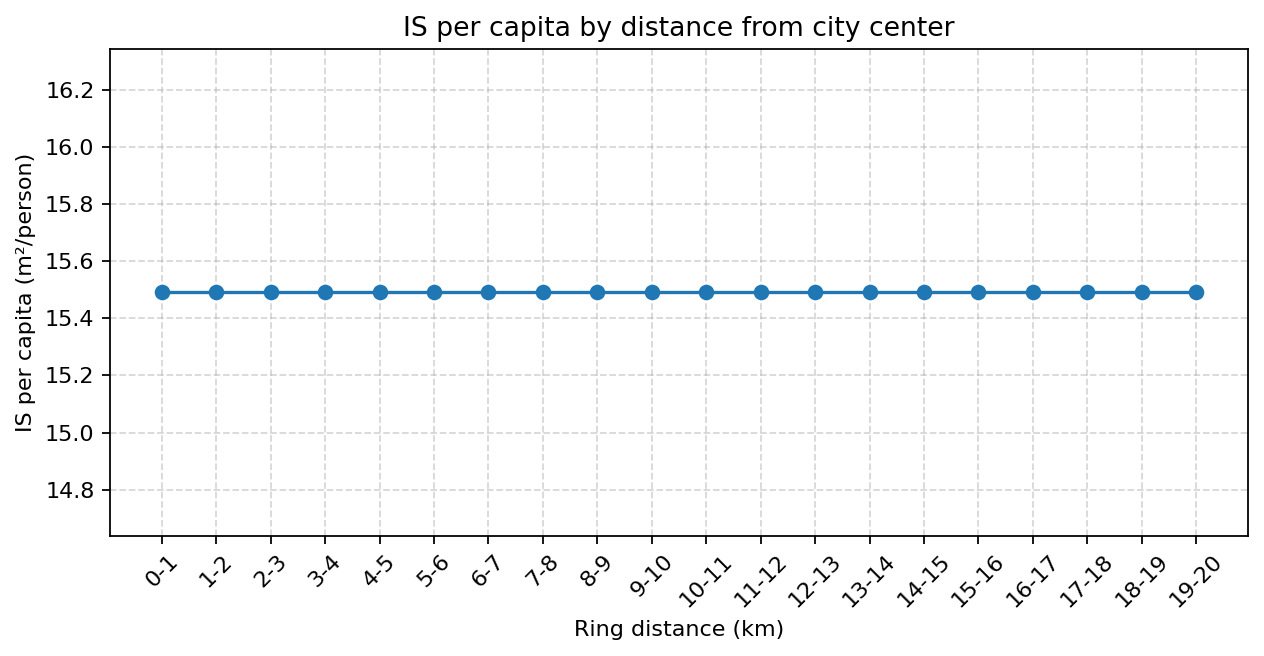

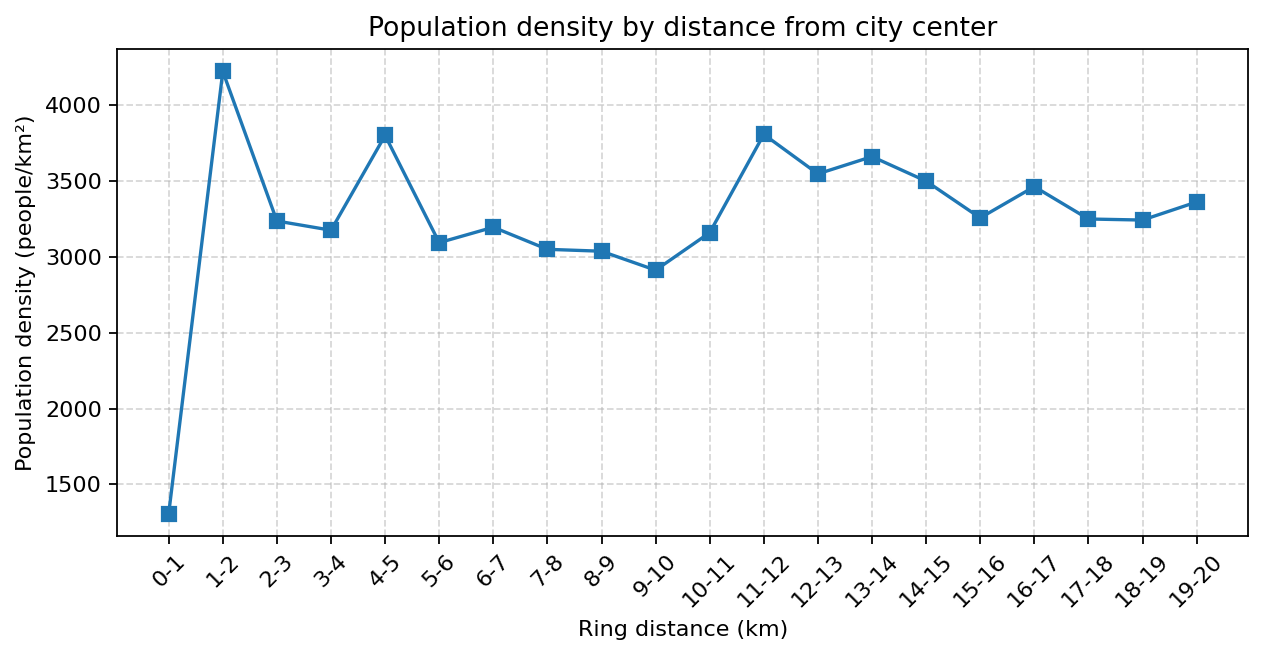

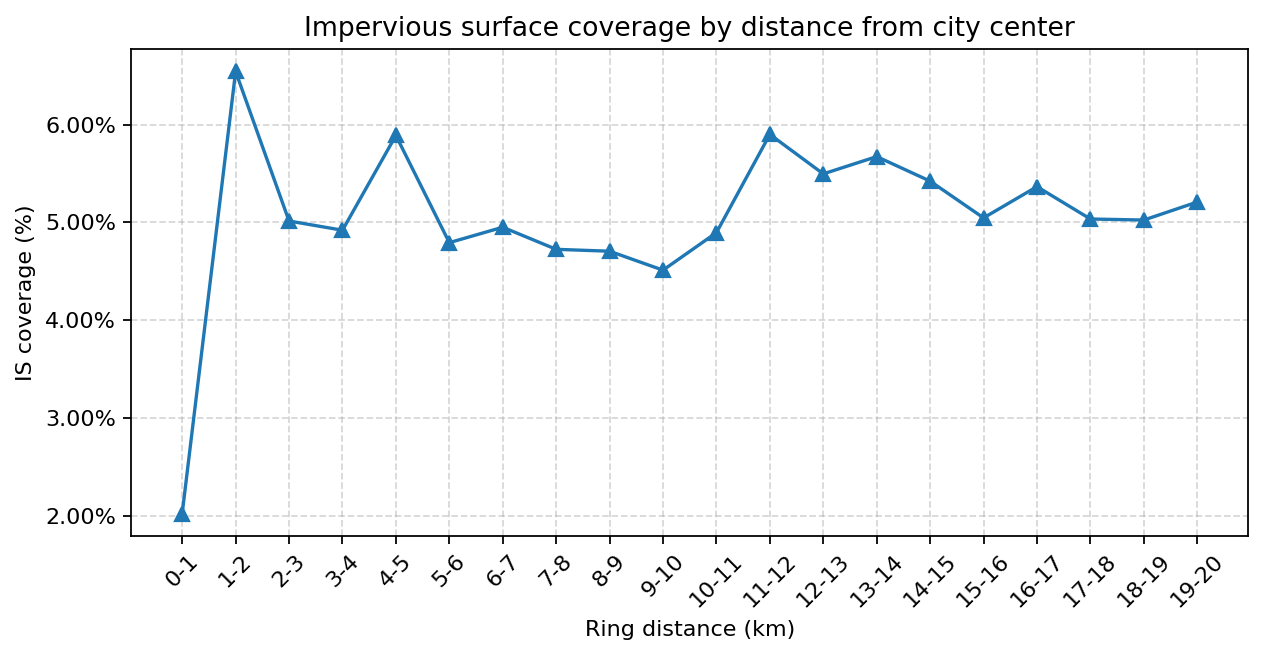

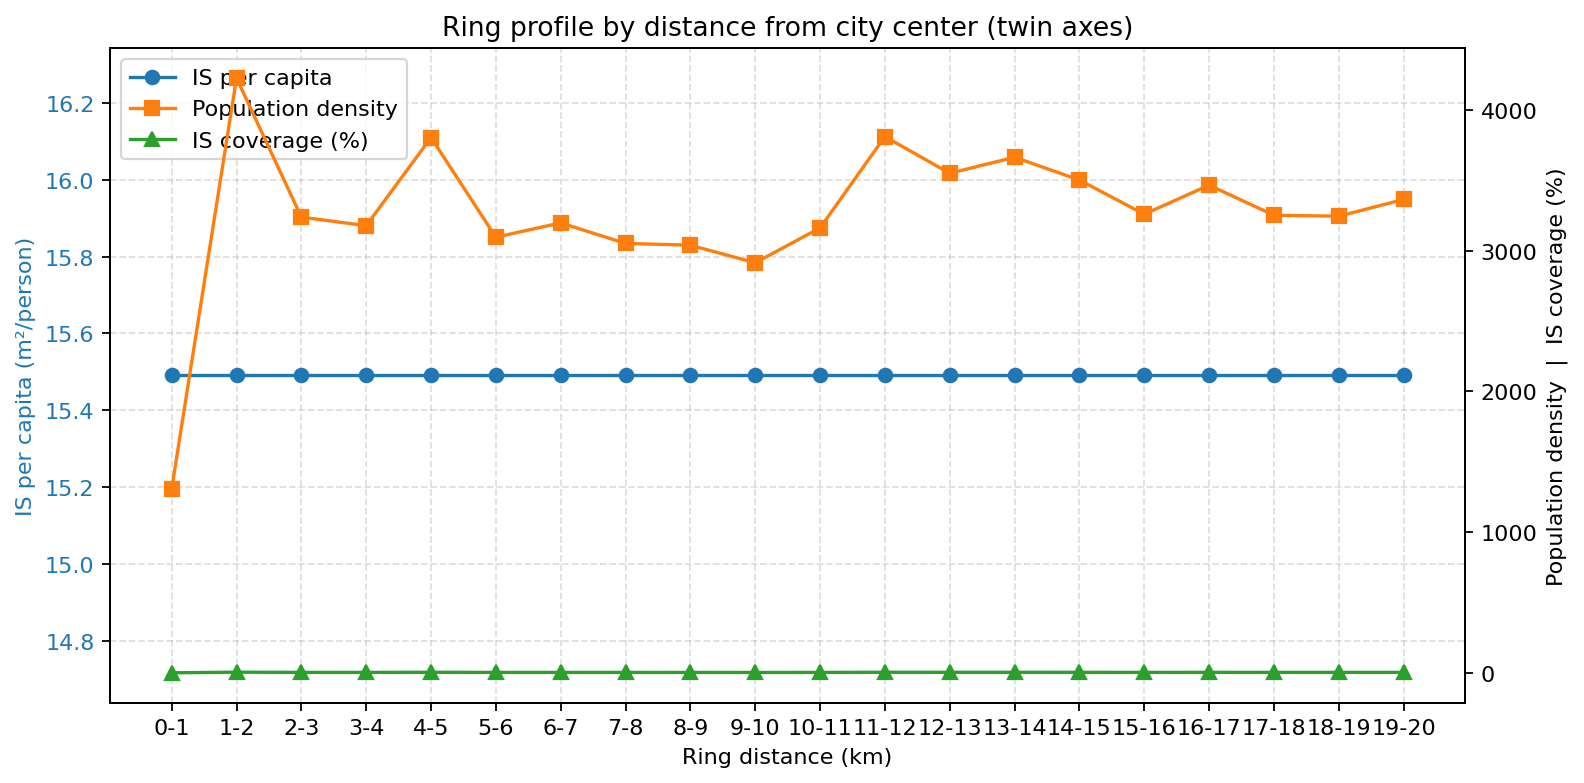

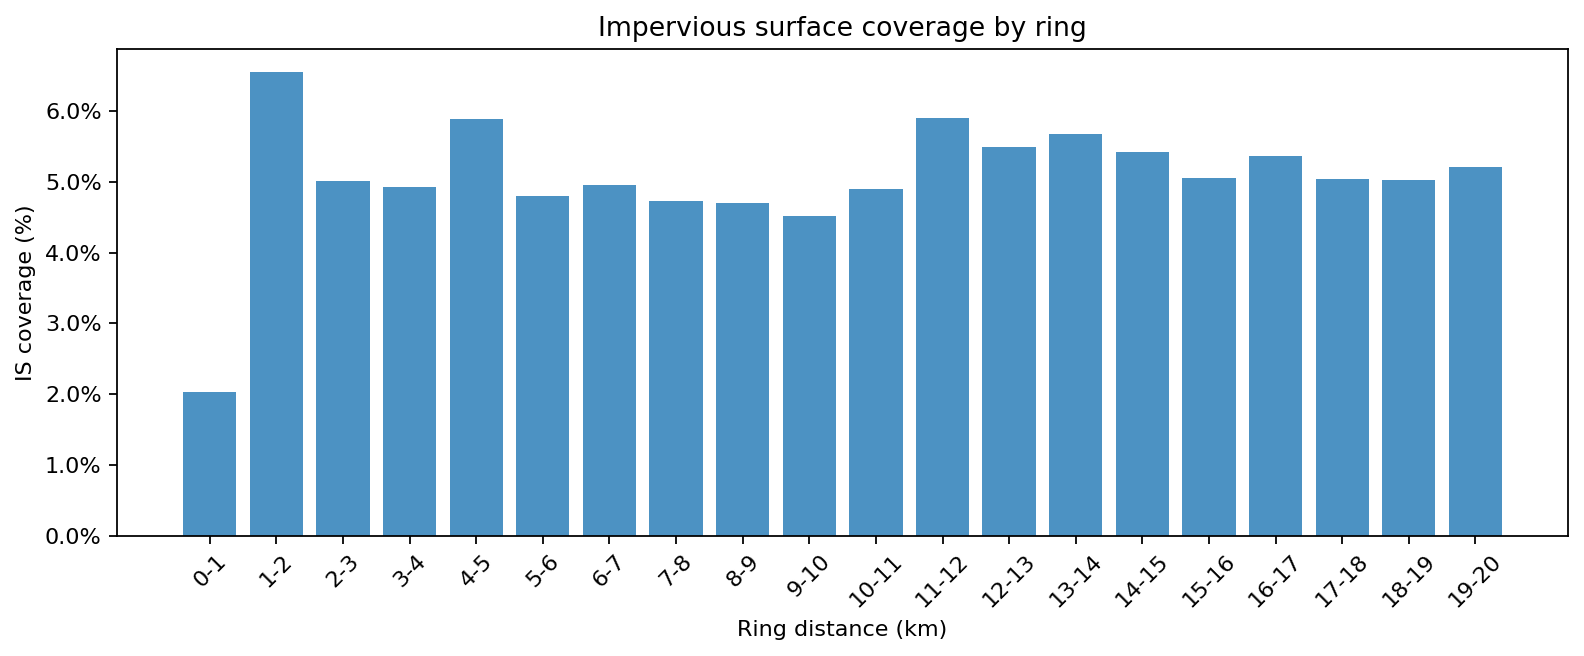

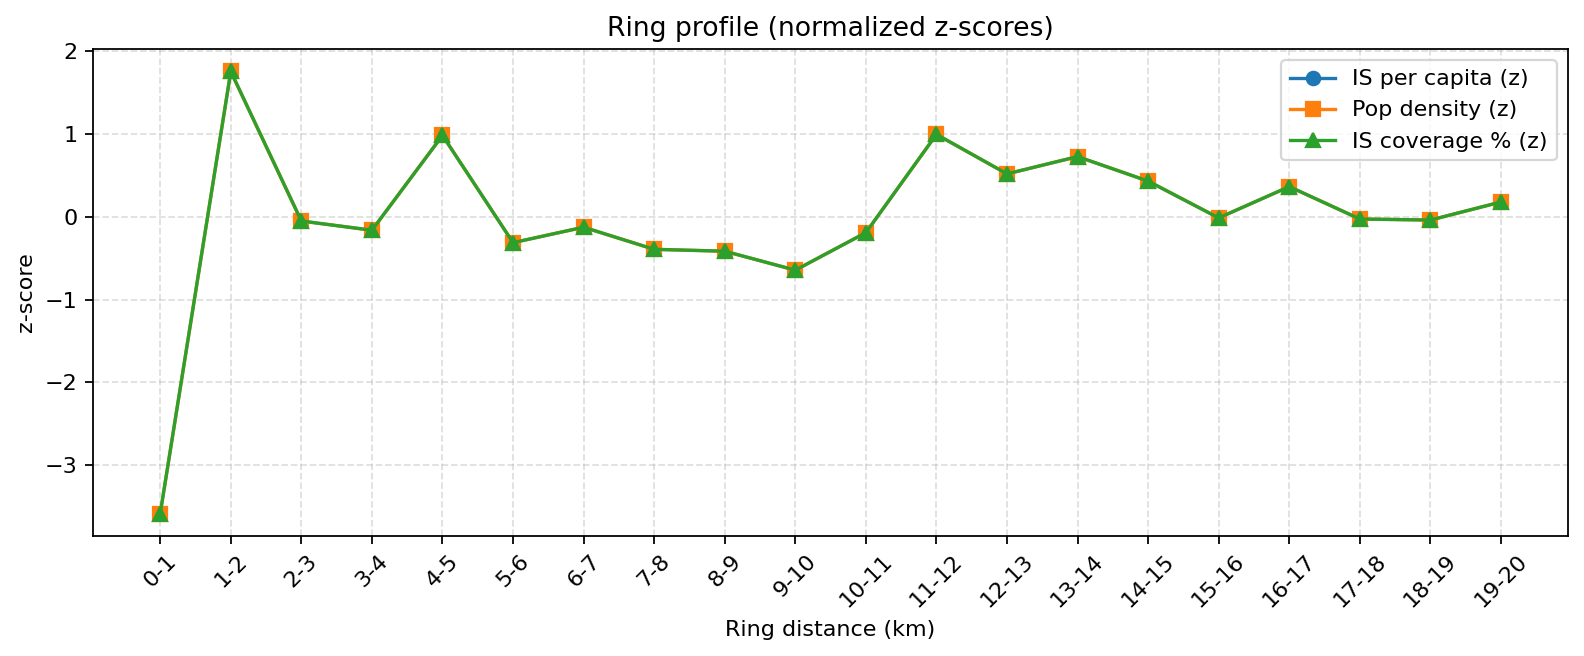

In [39]:
# 25. Graphs
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

# --- prepare & sort rings ---
rk = ring.copy()
def _bin_start(s):
    try: return float(str(s).split('-')[0])
    except: return np.inf
rk = rk.dropna(subset=["ring_km"]).copy()
rk["ring_start_km"] = rk["ring_km"].astype(str).map(_bin_start)
rk = rk.sort_values("ring_start_km")
x = rk["ring_km"].astype(str).values

# --- add IS coverage in percent ---
rk["is_coverage_pct"] = rk["is_density_km2"] * 100.0

# 1) Line plots (separate)
plt.figure(figsize=(8,4.2))
plt.plot(x, rk["is_per_capita_m2p"], marker="o")
plt.title("IS per capita by distance from city center")
plt.xlabel("Ring distance (km)"); plt.ylabel("IS per capita (m²/person)")
plt.xticks(rotation=45); plt.grid(True, linestyle="--", alpha=0.5); plt.tight_layout(); plt.show()

plt.figure(figsize=(8,4.2))
plt.plot(x, rk["pop_density_p_km2"], marker="s")
plt.title("Population density by distance from city center")
plt.xlabel("Ring distance (km)"); plt.ylabel("Population density (people/km²)")
plt.xticks(rotation=45); plt.grid(True, linestyle="--", alpha=0.5); plt.tight_layout(); plt.show()

plt.figure(figsize=(8,4.2))
plt.plot(x, rk["is_coverage_pct"], marker="^")
plt.gca().yaxis.set_major_formatter(PercentFormatter())  # show % ticks
plt.title("Impervious surface coverage by distance from city center")
plt.xlabel("Ring distance (km)"); plt.ylabel("IS coverage (%)")
plt.xticks(rotation=45); plt.grid(True, linestyle="--", alpha=0.5); plt.tight_layout(); plt.show()

# 2) Combined plot with twin y-axes:
fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(x, rk["is_per_capita_m2p"], marker="o", label="IS per capita")
ax1.set_xlabel("Ring distance (km)")
ax1.set_ylabel("IS per capita (m²/person)", color="C0")
ax1.tick_params(axis="y", labelcolor="C0")
ax1.grid(True, linestyle="--", alpha=0.4)

ax2 = ax1.twinx()
ax2.plot(x, rk["pop_density_p_km2"], marker="s", label="Population density", color="C1")
ax2.plot(x, rk["is_coverage_pct"], marker="^", label="IS coverage (%)", color="C2")
ax2.set_ylabel("Population density  |  IS coverage (%)")
ax2.yaxis.set_major_formatter(PercentFormatter() if rk["is_coverage_pct"].max()<=1.0 else ax2.yaxis.get_major_formatter())

# combine legends
lines = ax1.get_lines() + ax2.get_lines()
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc="upper left")
plt.title("Ring profile by distance from city center (twin axes)")
plt.xticks(rotation=45); plt.tight_layout(); plt.show()

# 3) Bar chart for IS coverage (%)
plt.figure(figsize=(10,4.2))
plt.bar(x, rk["is_coverage_pct"], alpha=0.8)
plt.gca().yaxis.set_major_formatter(PercentFormatter())
plt.title("Impervious surface coverage by ring")
plt.xlabel("Ring distance (km)"); plt.ylabel("IS coverage (%)")
plt.xticks(rotation=45); plt.tight_layout(); plt.show()

# (optional) Normalized comparison (z-score) to compare shapes only
from scipy.stats import zscore
plt.figure(figsize=(10,4.2))
plt.plot(x, zscore(rk["is_per_capita_m2p"]), marker="o", label="IS per capita (z)")
plt.plot(x, zscore(rk["pop_density_p_km2"]), marker="s", label="Pop density (z)")
plt.plot(x, zscore(rk["is_coverage_pct"]), marker="^", label="IS coverage % (z)")
plt.title("Ring profile (normalized z-scores)")
plt.xlabel("Ring distance (km)"); plt.ylabel("z-score")
plt.xticks(rotation=45); plt.legend(); plt.grid(True, linestyle="--", alpha=0.4); plt.tight_layout(); plt.show()

In [40]:
# 26. Gini
def gini(x):
    x = np.array(x, float); x = x[np.isfinite(x) & (x>=0)]
    if x.size<2 or x.sum()==0: return 0.0
    xs = np.sort(x); cum = np.cumsum(xs); n = xs.size
    return (n + 1 - 2*np.sum(cum)/cum[-1]) / n

print("Gini(IS) =", gini(grid["is_m2"]))
print("Gini(Pop)=", gini(grid["pop"]))

Gini(IS) = 0.33147643038427566
Gini(Pop)= 0.3314764303842754


In [41]:
# 27. Valid
valid = grid.replace([np.inf,-np.inf], np.nan).dropna(subset=["pop_density_p_km2","is_per_capita_m2p"])
print("corr =", valid["pop_density_p_km2"].corr(valid["is_per_capita_m2p"]))

corr = 0.007434081814233775


# **คำถาม**
**1.	จากการวิเคราะห์ ขนาด Impervious Surface รวมในพื้นที่ศึกษาเท่าไร?**

    พื้นที่ของ Impervious Surface = 760.29 km²
    พื้นที่ของ Impervious Surface ต่อคน = 1,300.92 m²/คน

**2.	Impervious Surface มีการกระจายอย่างสม่ำเสมอทั่วเมืองหรือไม่?**

     Impervious Surface (พื้นผิวที่น้ำซึมผ่านไม่ได้) ที่เป็นสีแดงกระจุกตัวหนาแน่นบริเวณริมแม่น้ำเจ้าพระยาทั้งสองฝั่ง
     โดยเฉพาะฝั่งเกาะรัตนโกสินทร์ โดยรวมคือกระจายสม่ำเสมอ
     ดูได้จากค่า Gini(IS) = 0.33 ค่าที่เข้าใกล้ 0 แปลว่ากระจายสม่ำเสมอ
     ส่วนสีขาวที่เป็นพื้นผิวที่น้ำซึมผ่านได้ (เช่น พื้นที่สีเขียว แหล่งน้ำต่าง ๆ) กระจายไม่ทั่วทั้งเมือง
     โดยกระจายหนาแน่นบริเวณชานเมืองที่ติดต่อกับปริมณฑลฝั่งตะวันตกรวมถึงเขตบางขุนเทียน
     และบริเวณปริมณฑลฝั่งตะวันออกมีการกระจายตัวค่อนข้างสม่ำเสมอ

**3.	เมื่อเปรียบเทียบกับจำนวนประชากรในเขตเมืองนั้น Impervious Surface ต่อคนอยู่ในระดับเพียงพอตามมาตรฐานหรือไม่?**

    Impervious Surface (พื้นผิวที่น้ำซึมผ่านไม่ได้) ที่เป็นสีแดงถือว่าสูงเมื่อเทียบกับจำนวนประชากร
    ส่วนพื้นผิวที่น้ำซึมผ่านได้ ถ้าเลือกเฉพาะพื้นที่สีเขียวนำมาคำนวณจะพบว่าไม่เพียงพอต่อประชากรในเขตเมือง
    โดยในปี 2566 มีพื้นที่สีเขียวต่อประชากรเท่ากับ 7.7 ตร.ม./คน ในขณะที่องค์การอนามัยโลก (WHO) กำหนดไว้ที่ 9 ตร.ม./คน

**4.	หากมีพื้นที่ใดขาดแคลน Impervious Surface นักศึกษาจะเสนอแนวทางเชิงนโยบายอย่างไร?**

    เนื่องจากกรุงเทพมหานครเป็นเมืองที่เพิ่มพื้นที่สีเขียวได้ค่อนข้างลำบากเนื่องจากมีสภาพความเป็นเมืองสูงมาอย่างยาวนาน
    (ส่วนที่เป็นพื้นที่สีเขียวส่วนใหญ่ในกรุงเทพจะเป็นสวนสาธารณะหรือพื้นที่เกษตรกรรม)
    ดังนั้นการเพิ่มพื้นที่สีเขียวที่เป็นไปได้ควรพัฒนาสิ่งที่มีอยู่เดิมให้ดียิ่งขึ้น
    เช่น เพิ่มพื้นที่สีเขียวตามริมถนนให้มีร่มเงา จัดการสวนสาธารณะเดิมที่มีอยู่ให้มีต้นไม้เพิ่มขึ้น (ที่เหมาะกับพื้นที่)
    ปรับปรุงพื้นที่รกร้างที่เต็มไปด้วยวัชพืชให้กลายเป็นสวนหย่อยเล็ก ๆ ที่สามารถเข้าไปใช้งานได้ เป็นต้น

# **Code Snippet**

**1. กำหนดขอบเขตพื้นที่ศึกษา**

    FC = ee.FeatureCollection('projects/ee-pannarai/assets/BKK_2566')

    FC = FC.map(lambda f: f.setGeometry(f.geometry().buffer(1))) # Changed buffer(0) to buffer(1)

    AOI = FC.union(1).geometry()  # รวมเป็น geometry เดียว
    print('AOI area (km²):', AOI.area(1).getInfo()/1e6)

    Map = geemap.Map()
    Map.centerObject(AOI, 10)
    Map.addLayer(AOI, {}, 'AOI')
    Map

**2. คำนวณดัชนี NDVI เพื่อนำไปจำแนก Impervious Surface**

    def mask_s2_sr(img):
       scl = img.select('SCL')
       mask = (scl.neq(3)   # cloud shadow
            .And(scl.neq(8))  # cloud (med)
            .And(scl.neq(9))  # cloud (high)
            .And(scl.neq(10)) # thin cirrus
            .And(scl.neq(11)))# snow/ice
    return img.updateMask(mask)

    s2 = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
           .filterBounds(AOI)
          .filterDate('2024-01-01', '2024-12-31')
          .filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', 40))
          .map(mask_s2_sr))

    s2_med = s2.median().clip(AOI)
    ndvi   = s2_med.normalizedDifference(['B8','B4']).rename('NDVI')

    lulc = ee.ImageCollection('ESA/WorldCover/v200').first().select('Map').clip(AOI)
    IS   = lulc.eq(50).selfMask().rename('IS')

    try:
        Map
    except NameError:
        Map = geemap.Map()
    Map.centerObject(AOI, 11)

    ndvi_vis = {
        'min': 0.0, 'max': 1.0,
       'palette': ['#d73027','#fdae61','#fee08b','#d9ef8b','#66bd63','#1a9850']
        }

    Map.addLayer(ndvi, ndvi_vis, 'NDVI (S2, 2024)')
    Map.addLayer(IS, {'palette': ['#313131']}, 'IS (WorldCover v200: built-up)')
    Map.addLayer(AOI, {'color': '#0000ff'}, 'AOI', False)
    Map

**3. คำนวณพื้นที่ Impervious Surface**

    pixel_area  = ee.Image.pixelArea()
    is_area_img = pixel_area.updateMask(IS)
    tot_area_img= pixel_area.clip(AOI)

    areaIS = ee.Number(is_area_img.reduceRegion(
        reducer=ee.Reducer.sum(), geometry=AOI, scale=10, maxPixels=1e13
    ).get('area'))

    areaTot = ee.Number(tot_area_img.reduceRegion(
        reducer=ee.Reducer.sum(), geometry=AOI, scale=10, maxPixels=1e13
    ).get('area'))

    pctIS = areaIS.divide(areaTot).multiply(100)

    print('IS area (km²):', areaIS.getInfo()/1e6)
    print('Total area (km²):', areaTot.getInfo()/1e6)
    print('IS ratio (%):', pctIS.getInfo())
  
**4. Zonal stats by zones (clean geometry + AOI intersect + export)**

    IS_BIN = IS.gt(0).selfMask()

    def _clean_clip(f):
       g = ee.Geometry(f.geometry())
       g = g.simplify(1)          # ~1 m
       g = g.buffer(0, 1)         # errorMargin 1 m
       g = g.intersection(AOI, 1) # ตัดให้เหลือใน AOI
       return ee.Feature(f).setGeometry(g)

    ZONES_FC_AOI = FC.map(_clean_clip).filterBounds(AOI)
    img_area = ee.Image.pixelArea().updateMask(IS_BIN).clip(AOI)

    zonal_all = img_area.reduceRegions(
        collection=ZONES_FC_AOI,
        reducer=ee.Reducer.sum().setOutputs(['is_m2']),
        scale=10,
        tileScale=4
    ).map(lambda f: f.set({
        'zone_area_m2': f.geometry().area(1),
        'is_pct': ee.Number(f.get('is_m2')).divide(f.geometry().area(1)).multiply(100)
    }))

    def _finalize(f):
        f = f.set({
            'prov_name_th': f.get('PROV_NAM_T'),
            'prov_code':    f.get('PROV_CODE'),
            'zone_id': ee.Algorithms.If(
                f.propertyNames().contains('ID'),
                f.get('ID'),
                f.get('PROV_CODE')
            ),
            'is_m2':        ee.Number(f.get('is_m2')),
            'zone_area_m2': ee.Number(f.get('zone_area_m2')),
            'is_pct':       ee.Number(f.get('is_pct'))
        })
        return f.select(['prov_name_th','prov_code','zone_id','is_m2','zone_area_m2','is_pct'])

    zonal_clean = zonal_all.map(_finalize)

**5. Impervious Surface Map**

    import geopandas as gpd
    import folium
    import rasterio
    import numpy as np

    tif_path = "/content/IS_mask_BKK.tif"
    with rasterio.open(tif_path) as src:
        img = src.read(1)
        bounds = src.bounds

    rgba = np.zeros((img.shape[0], img.shape[1], 4), dtype=np.uint8)
    rgba[img == 1] = [255, 0, 0, 255]

    center_lat = (bounds.top + bounds.bottom) / 2
    center_lon = (bounds.left + bounds.right) / 2

    m = folium.Map(location=[center_lat, center_lon], zoom_start=10)

    folium.raster_layers.ImageOverlay(
        image=rgba,
        bounds=[[bounds.bottom, bounds.left], [bounds.top, bounds.right]],
        opacity=1.0,
        name="IS Mask"
    ).add_to(m)

    shp_path = "/content/BKK_2566.shp"
    gdf = gpd.read_file(shp_path).to_crs(epsg=4326)

    for c in gdf.columns:
        if c != "geometry" and "datetime64" in str(gdf[c].dtype):
            gdf[c] = gdf[c].dt.strftime("%Y-%m-%d")

    tooltip_fields = [c for c in gdf.columns if c != "geometry"][:2]

    folium.GeoJson(
        data=gdf.to_json(),
        name="ขอบเขตเมืองกรุงเทพ",
        style_function=lambda x: {"color": "blue", "weight": 2, "fillOpacity": 0},
        tooltip=folium.GeoJsonTooltip(fields=tooltip_fields)
    ).add_to(m)

    folium.LayerControl().add_to(m)
    m

**6. สัดส่วน Impervious Surface**

    import pandas as pd
    import matplotlib as mp
    import matplotlib.pyplot as plt

    df = pd.read_csv('/content/impervious_zonal_BKK.csv', encoding='utf-8-sig')
    df['is_m2'] = pd.to_numeric(df['is_m2'], errors='coerce')
    df['zone_area_m2'] = pd.to_numeric(df['zone_area_m2'], errors='coerce')

    is_m2  = df['is_m2'].sum()
    tot_m2 = df['zone_area_m2'].sum()
    non_is_m2 = tot_m2 - is_m2

    is_km2     = is_m2 / 1e6
    non_is_km2 = non_is_m2 / 1e6
    is_pct_overall = (is_m2 / tot_m2) * 100

    fig, ax = plt.subplots(figsize=(3,3), dpi=240)

    values = [is_km2, non_is_km2]
    labels = [f'IS\n{is_km2:,.1f} km²', f'Non-IS\n{non_is_km2:,.1f} km²']

    def autopct_fmt(pct):
        return f'{pct:.1f}%'

    wedges, texts, autotexts = ax.pie(
        values,
        labels=labels,
        autopct=autopct_fmt,
        startangle=50,
        pctdistance=0.78,
        labeldistance=1.10,
        wedgeprops=dict(linewidth=1, edgecolor='white'),
        textprops=dict(fontsize=7)
    )

    ax.set_title('Impervious vs Non-Impervious (Area Share)', fontsize=8)
    ax.set_aspect('equal')  # วงกลมจริง

    plt.tight_layout()
    plt.show()

**7. Impervious Surface ต่อคน (m²/คน)**

    import pandas as pd

    df = pd.read_csv('/content/impervious_zonal_BKK.csv', encoding='utf-8-sig')
    df['is_m2'] = pd.to_numeric(df['is_m2'], errors='coerce')

    is_area_m2 = df['is_m2'].sum()
    total_pop  = 5_471_588

    is_per_capita = is_area_m2 / total_pop
    print(f'IS per capita = {is_per_capita:,.2f} m²/person')

**8. การกระจายตัวและอัตราส่วน Impervious Surface ต่อพื้นที่เมือง (%)**

    import rasterio
    from rasterio.warp import calculate_default_transform, reproject, Resampling

    src = "/content/IS_mask_BKK.tif"
    dst = "/content/IS_mask_BKK.tif"

    with rasterio.open(src) as r:
        dst_crs = "EPSG:32647"
        transform, width, height = calculate_default_transform(
            r.crs, dst_crs, r.width, r.height, *r.bounds, resolution=30
        )
        profile = r.profile.copy()
        profile.update({
            "crs": dst_crs,
            "transform": transform,
            "width": width,
            "height": height,
            "nodata": 0
        })
        with rasterio.open(dst, "w", **profile) as out:
            reproject(
                source=r.read(1),
                destination=rasterio.band(out, 1),
                src_transform=r.transform,
                src_crs=r.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest
            )
    print("รีโปรเจ็กต์เสร็จแล้ว:", dst)

**9. ค่าการกระจายความสม่ำเสมอ**

    def gini(x):
        x = np.array(x, float); x = x[np.isfinite(x) & (x>=0)]
        if x.size<2 or x.sum()==0: return 0.0
        xs = np.sort(x); cum = np.cumsum(xs); n = xs.size
        return (n + 1 - 2*np.sum(cum)/cum[-1]) / n

    print("Gini(IS) =", gini(grid["is_m2"]))
    print("Gini(Pop)=", gini(grid["pop"]))